In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%pylab inline
%load_ext autoreload
%autoreload 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys
sys.path.append('../src/lib/')
sys.path.insert(0, '../../.conda/envs/mktrack/lib/python3.8/site-packages')

import torch
import glob
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2
import torch.nn.functional as F
from torchmetrics.detection import MeanAveragePrecision
from torchvision.transforms import transforms as T
import torchvision
from tqdm import tqdm

In [5]:
from models.model import create_model, load_model
import datasets.dataset as dataset
from models.decode import mot_decode, _topk, map2orig

#### Load data

In [4]:
dset = dataset.ImageLabelDataset(
    root='/usr/users/agecker/datasets/lemur_ids/',
    file_list='/usr/users/vogg/monkey-tracking-in-the-wild/src/data/lemur_ids.val',
    resize=True
    )

In [5]:
class_names = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red', 'Uns']

### Midpoint classification

In [31]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 128}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = False)

print(os.getcwd())
model = load_model(model, '../exp/mot/lemur_ids/model_14.pth')
model = model.to(torch.device('cuda'))
model.eval();

/usr/users/vogg/monkey-tracking-in-the-wild/notebooks
loaded ../exp/mot/lemur_ids/model_14.pth, epoch 14


In [32]:
accuracy = 0
gt = []
pred = []

for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
    
    image, img_path, original_shape, labels = dset.__getitem__(i)
    im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

    width = im_blob.shape[3]
    height = im_blob.shape[2]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4



    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']
        
        num_classes = hm.size(1)

        dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)
        
        # Spatial indices of lemur detections
        lemur_detect_inds = inds[:, cls_inds_mask[0]]

        # Id classification logits per lemur detection
        cls_logits = model.gc_lin(output['gc'], lemur_detect_inds).cpu().numpy()

    # Translate and scale bounding box detections.
    dets = map2orig(dets, h_out, w_out, height, width, num_classes)
    
    
    # Only keep lemur predictions.
    dets_bbox = dets[0]
    dets_class = np.argmax(cls_logits, axis=1)
    dets_conf = np.max(cls_logits, axis = 1)


    remain_inds = dets_bbox[:, 4] > 0.01
    dets_bbox = dets_bbox[remain_inds]
    dets_class = dets_class[remain_inds]
    dets_conf = dets_conf[remain_inds]
    
    # Only keep lemur ground truth boxes.
    labels = labels[labels[:, 0]==0]

    # Translate and scale ground truth bounding boxes.
    gt_bbox = torch.Tensor(labels[:, 2:6]) # * np.array([width, height, width, height]))
#     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")
    
    assert gt_bbox.size(0) == 1
    
    iou_matrix = torchvision.ops.box_iou(gt_bbox, torch.from_numpy(dets_bbox[:, :4])).numpy()
    
    #print("pred", dets_class[np.argmax(iou_matrix)])
    #print("gt", int(labels[:, -1]))
    gt.append(class_names[dets_class[np.argmax(iou_matrix)]])
    pred.append(class_names[int(labels[:, -1])])
    #print(class_names[dets_class[np.argmax(iou_matrix)]])
    #print(class_names[int(labels[:, -1])])
    #print(np.max(iou_matrix))
    accuracy += int(dets_class[np.argmax(iou_matrix)] == int(labels[:, -1]))

    #print("conf", dets_conf[np.argmax(iou_matrix)])

accuracy /= i + 1

100%|██████████| 34/34 [00:02<00:00, 11.45it/s]


In [33]:
accuracy

0.38235294117647056

### ROI model

In [51]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 3}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = True)

print(os.getcwd())
model = load_model(model, '../exp/mot/lemur_ids_roi/model_40.pth')
model = model.to(torch.device('cuda'))
model.eval();

/usr/users/vogg/monkey-tracking-in-the-wild/notebooks
loaded ../exp/mot/lemur_ids_roi/model_40.pth, epoch 40


In [55]:
accuracy = 0
gt = []
pred = []

for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
    
    image, img_path, original_shape, labels = dset.__getitem__(i)
    im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

    width = im_blob.shape[3]
    height = im_blob.shape[2]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4



    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']
        
        num_classes = hm.size(1)

        dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)

    # Translate and scale bounding box detections.
    dets = map2orig(dets, h_out, w_out, height, width, num_classes)
    
    # Only keep lemur predictions.
    dets = dets[0]
    dets_bbox = torch.from_numpy(dets)
    remain_inds = dets_bbox[:, 4] > 0.1
    dets_bbox = dets_bbox[remain_inds]
    
    # Only keep lemur ground truth boxes.
    labels = labels[labels[:, 0]==0]

    # Id classification logits per lemur detection
    #cls_logits = model.gc_lin(output['gc'], bboxes=[dets_bbox[:, :4].cuda() / 4]).cpu()
    cls_logits = model.gc_lin(im_blob, bboxes=[dets_bbox[:, :4].cuda() / 4]).cpu()
    dets_class = torch.argmax(cls_logits, dim=1)
    
    # Only keep lemur ground truth boxes.
    labels = labels[labels[:, 0]==0]

    # Translate and scale ground truth bounding boxes.
    gt_bbox = torch.Tensor(labels[:, 2:6]) # * np.array([width, height, width, height]))
#     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")
    
    assert gt_bbox.size(0) == 1
    
    iou_matrix = torchvision.ops.box_iou(gt_bbox, dets_bbox[:, :4]).numpy()
    
    accuracy += int(dets_class[np.argmax(iou_matrix)] == int(labels[:, -1]))
    gt.append(class_names[dets_class[np.argmax(iou_matrix)]])
    pred.append(class_names[int(labels[:, -1])])

accuracy /= i + 1

100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


In [56]:
accuracy

0.5588235294117647

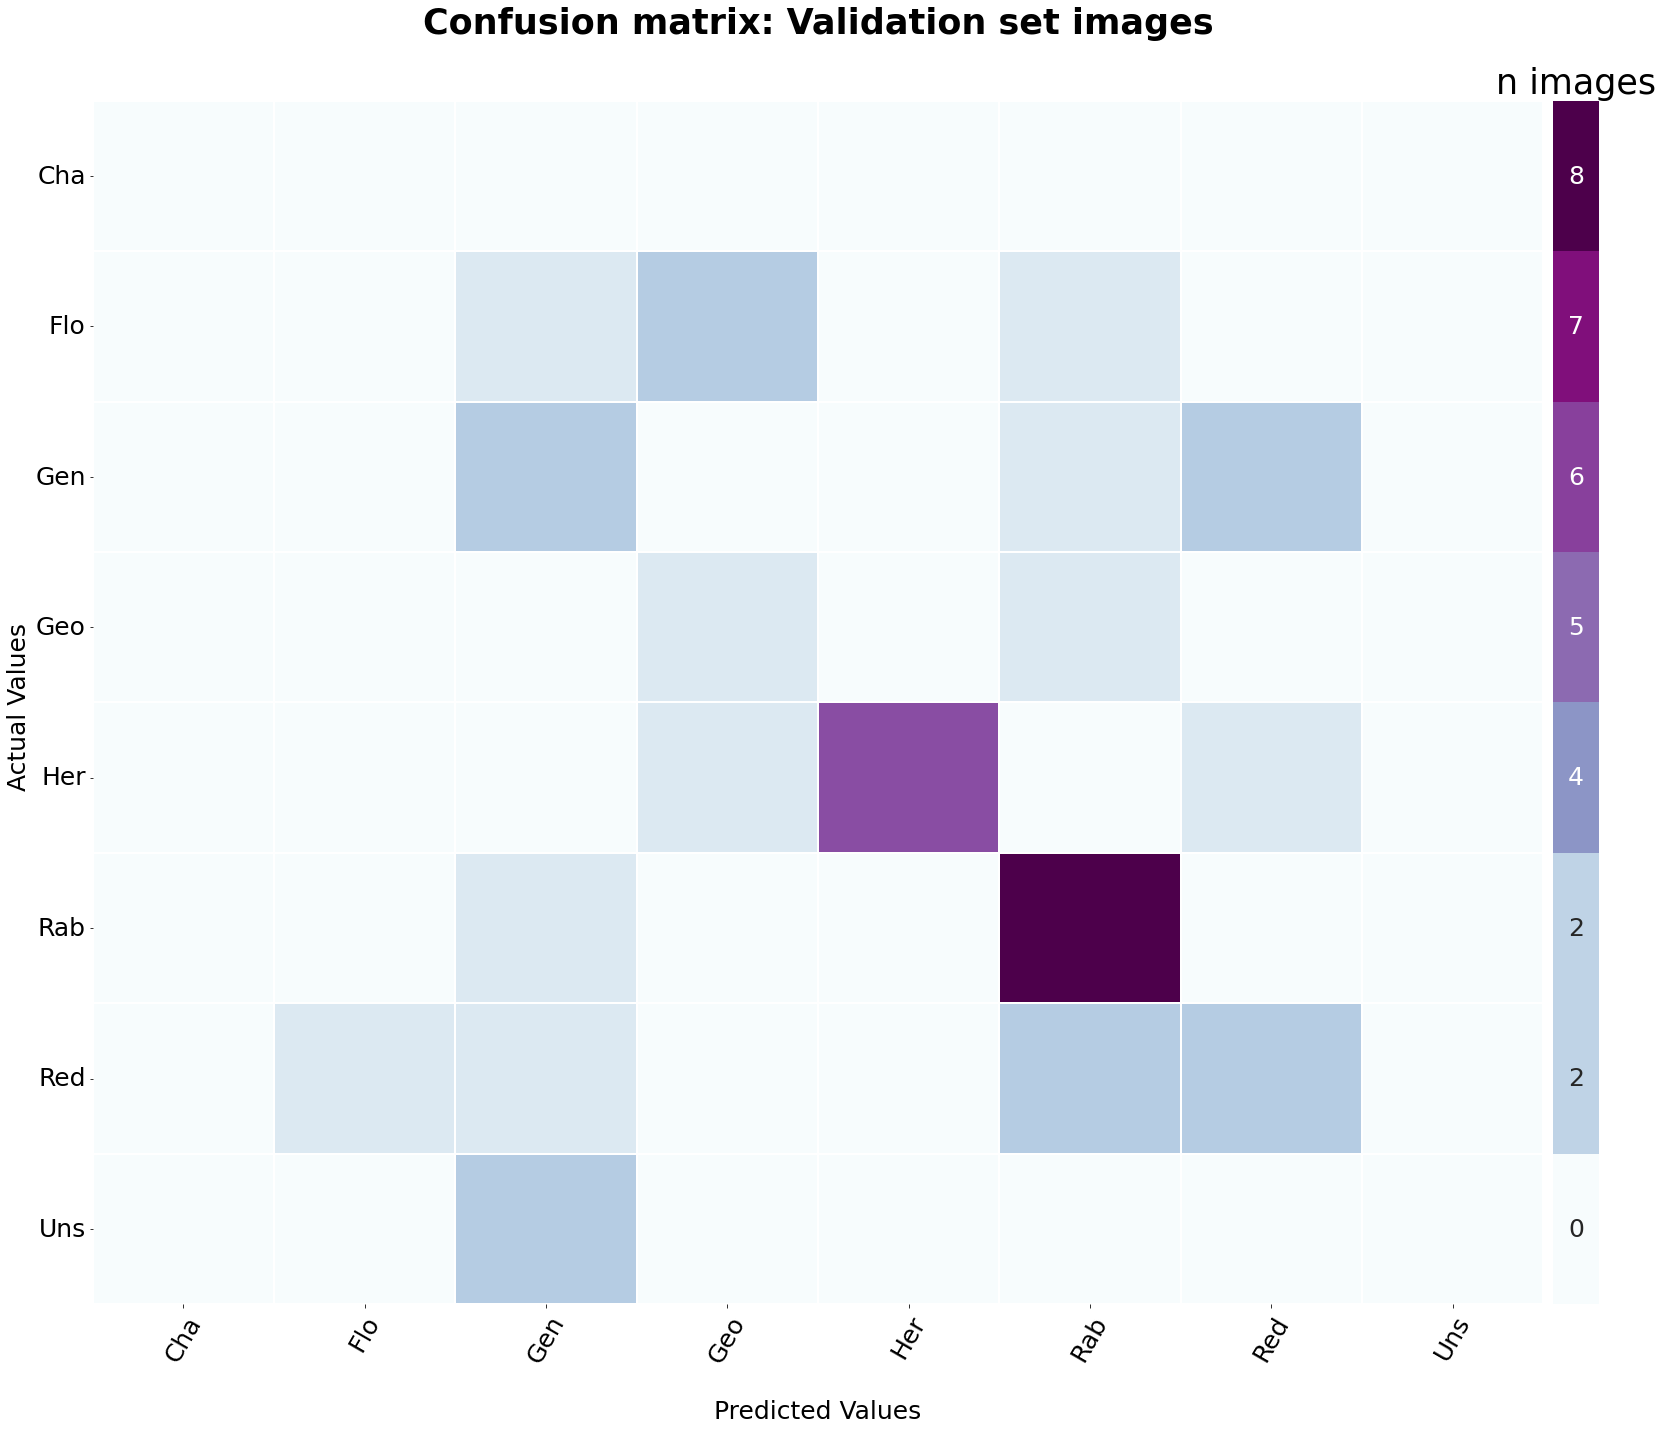

In [30]:
#Make plot
cm_full = confusion_matrix(pred, gt, labels = sorted(class_names)) #for row sums

n_training_photos = cm_full.sum(axis = 1)
n_sorted = sorted(n_training_photos, reverse = True)
ids_sorted = sorted(class_names, reverse = False)
cm = cm_full #df.reindex(index = ids_sorted, columns = ids_sorted)

plt.figure(figsize=(27, 23))
ax1 = plt.subplot2grid((27,27), (0,0), colspan=26, rowspan=26)
ax2 = plt.subplot2grid((27,27), (0,26), colspan=1, rowspan=26)

conf_mat = sn.heatmap(cm, cmap='BuPu', linewidths = 2, annot = False, cbar = False, ax = ax1, fmt = '.1g', annot_kws={"size": 25})

sn.heatmap(pd.DataFrame(n_sorted), ax=ax2,  annot=True, cmap="BuPu", 
           cbar=False, xticklabels=False, yticklabels=False, fmt='g', annot_kws={"size": 25});

title_text = "Confusion matrix: Validation set images"

#subtitle_text = "probabilities (summed and softmaxed)"
    
conf_mat.text(x=0.5, y=1.05, s=title_text, fontsize=35, weight='bold', ha='center', va='bottom', transform=conf_mat.transAxes)
#conf_mat.text(x=0.5, y=1.02, s=subtitle_text, fontsize=18, alpha=0.75, ha='center', va='bottom', transform=conf_mat.transAxes)

conf_mat.set_xticklabels(ids_sorted, rotation=60, fontsize = 25)
conf_mat.set_yticklabels(ids_sorted, rotation=0, fontsize = 25)
conf_mat.set_xlabel('\nPredicted Values', fontsize = 25)
conf_mat.set_ylabel('Actual Values ', fontsize = 25)
ax2.set_title('n images', fontsize = 35)

plt.show()

### Several models: midpoints

In [10]:
accuracies = list()

for i in range(10, 121, 10):
    model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 128}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = False)

    model = load_model(model, '../exp/mot/lemur_ids_only_gc_80_1e-5/model_'+str(i)+'.pth')
    model = model.to(torch.device('cuda'))
    model.eval()


    accuracy = 0
    gt = []
    pred = []

    for i in tqdm(range(dset.__len__())):
    # for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
        
        image, img_path, original_shape, labels = dset.__getitem__(i)
        im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

        width = im_blob.shape[3]
        height = im_blob.shape[2]
        inp_height = im_blob.shape[2]
        inp_width = im_blob.shape[3]
        h_out = inp_height // 4
        w_out = inp_width // 4



        with torch.no_grad():
            output = model(im_blob)[-1]
            hm = output['hm'].sigmoid_()
            wh = output['wh']
            id_feature = output['id']
            id_feature = F.normalize(id_feature, dim=1)
            reg = output['reg']
            
            num_classes = hm.size(1)

            dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                            wh=wh,
                                            reg=reg,
                                            num_classes=num_classes,
                                            cat_spec_wh=False,
                                            K=50)
            
            # Spatial indices of lemur detections
            lemur_detect_inds = inds[:, cls_inds_mask[0]]

            # Id classification logits per lemur detection
            cls_logits = model.gc_lin(output['gc'], lemur_detect_inds).cpu().numpy()

        # Translate and scale bounding box detections.
        dets = map2orig(dets, h_out, w_out, height, width, num_classes)
        
        
        # Only keep lemur predictions.
        dets_bbox = dets[0]
        dets_class = np.argmax(cls_logits, axis=1)
        dets_conf = np.max(cls_logits, axis = 1)


        remain_inds = dets_bbox[:, 4] > 0.01
        dets_bbox = dets_bbox[remain_inds]
        dets_class = dets_class[remain_inds]
        dets_conf = dets_conf[remain_inds]
        
        # Only keep lemur ground truth boxes.
        labels = labels[labels[:, 0]==0]

        # Translate and scale ground truth bounding boxes.
        gt_bbox = torch.Tensor(labels[:, 2:6]) # * np.array([width, height, width, height]))
    #     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")
        
        assert gt_bbox.size(0) == 1
        
        iou_matrix = torchvision.ops.box_iou(gt_bbox, torch.from_numpy(dets_bbox[:, :4])).numpy()
        
        #print("pred", dets_class[np.argmax(iou_matrix)])
        #print("gt", int(labels[:, -1]))
        gt.append(class_names[dets_class[np.argmax(iou_matrix)]])
        pred.append(class_names[int(labels[:, -1])])
        accuracy += int(dets_class[np.argmax(iou_matrix)] == int(labels[:, -1]))

        #print("conf", dets_conf[np.argmax(iou_matrix)])

    accuracy /= i + 1
    accuracies.append(accuracy)

loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_10.pth, epoch 10


100%|██████████| 34/34 [00:02<00:00, 11.76it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_20.pth, epoch 20


100%|██████████| 34/34 [00:02<00:00, 11.88it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_30.pth, epoch 30


100%|██████████| 34/34 [00:02<00:00, 11.94it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_40.pth, epoch 40


100%|██████████| 34/34 [00:02<00:00, 11.89it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_50.pth, epoch 50


100%|██████████| 34/34 [00:02<00:00, 11.94it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_60.pth, epoch 60


100%|██████████| 34/34 [00:02<00:00, 11.73it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_70.pth, epoch 70


100%|██████████| 34/34 [00:02<00:00, 11.88it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_80.pth, epoch 80


100%|██████████| 34/34 [00:02<00:00, 11.86it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_90.pth, epoch 90


100%|██████████| 34/34 [00:02<00:00, 11.83it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_100.pth, epoch 100


100%|██████████| 34/34 [00:02<00:00, 11.79it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_110.pth, epoch 110


100%|██████████| 34/34 [00:02<00:00, 11.75it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_120.pth, epoch 120


100%|██████████| 34/34 [00:02<00:00, 11.87it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_130.pth, epoch 130


100%|██████████| 34/34 [00:02<00:00, 11.82it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_140.pth, epoch 140


100%|██████████| 34/34 [00:02<00:00, 11.69it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_150.pth, epoch 150


100%|██████████| 34/34 [00:02<00:00, 11.85it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_160.pth, epoch 160


100%|██████████| 34/34 [00:02<00:00, 11.89it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_170.pth, epoch 170


100%|██████████| 34/34 [00:02<00:00, 11.82it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_180.pth, epoch 180


100%|██████████| 34/34 [00:02<00:00, 11.84it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_190.pth, epoch 190


100%|██████████| 34/34 [00:02<00:00, 11.81it/s]


loaded ../exp/mot/lemur_ids_only_gc_80_1e-5/model_200.pth, epoch 200


100%|██████████| 34/34 [00:02<00:00, 11.87it/s]


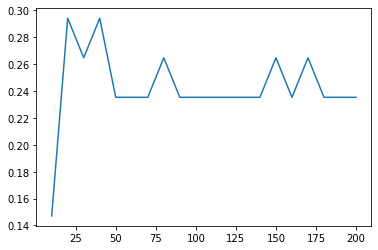

In [11]:
plt.plot(range(10, 201, 10), accuracies)

### Several models: ROI

In [57]:
accuracies = list()


for i in range(2, 51, 2):
    model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 3}, 
                    head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = True)

    model = load_model(model, f'../exp/mot/lemur_ids_roi/model_{str(i)}.pth')
    model = model.to(torch.device('cuda'))
    model.eval();


    accuracy = 0
    gt = []
    pred = []

    for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
            
        image, img_path, original_shape, labels = dset.__getitem__(i)
        im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

        width = im_blob.shape[3]
        height = im_blob.shape[2]
        inp_height = im_blob.shape[2]
        inp_width = im_blob.shape[3]
        h_out = inp_height // 4
        w_out = inp_width // 4



        with torch.no_grad():
            output = model(im_blob)[-1]
            hm = output['hm'].sigmoid_()
            wh = output['wh']
            id_feature = output['id']
            id_feature = F.normalize(id_feature, dim=1)
            reg = output['reg']
            
            num_classes = hm.size(1)

            dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                            wh=wh,
                                            reg=reg,
                                            num_classes=num_classes,
                                            cat_spec_wh=False,
                                            K=50)

        # Translate and scale bounding box detections.
        dets = map2orig(dets, h_out, w_out, height, width, num_classes)
        
        # Only keep lemur predictions.
        dets = dets[0]
        dets_bbox = torch.from_numpy(dets)
        remain_inds = dets_bbox[:, 4] > 0.04
        dets_bbox = dets_bbox[remain_inds]
        
        # Only keep lemur ground truth boxes.
        labels = labels[labels[:, 0]==0]

        # Id classification logits per lemur detection
        #cls_logits = model.gc_lin(output['gc'], bboxes=[dets_bbox[:, :4].cuda() / 4]).cpu()
        cls_logits = model.gc_lin(im_blob, bboxes=[dets_bbox[:, :4].cuda() / 4]).cpu()
        dets_class = torch.argmax(cls_logits, dim=1)

        # Translate and scale ground truth bounding boxes.
        gt_bbox = torch.Tensor(labels[:, 2:6]) # * np.array([width, height, width, height]))
    #     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")
        
        assert gt_bbox.size(0) == 1
        
        iou_matrix = torchvision.ops.box_iou(gt_bbox, dets_bbox[:, :4]).numpy()
        
        accuracy += int(dets_class[np.argmax(iou_matrix)] == int(labels[:, -1]))
        gt.append(class_names[dets_class[np.argmax(iou_matrix)]])
        pred.append(class_names[int(labels[:, -1])])

    accuracy /= i + 1
    accuracies.append(accuracy)

loaded ../exp/mot/lemur_ids_roi/model_2.pth, epoch 2


100%|██████████| 34/34 [00:03<00:00, 11.26it/s]


loaded ../exp/mot/lemur_ids_roi/model_4.pth, epoch 4


100%|██████████| 34/34 [00:03<00:00, 11.26it/s]


loaded ../exp/mot/lemur_ids_roi/model_6.pth, epoch 6


100%|██████████| 34/34 [00:02<00:00, 11.44it/s]


loaded ../exp/mot/lemur_ids_roi/model_8.pth, epoch 8


100%|██████████| 34/34 [00:02<00:00, 11.50it/s]


loaded ../exp/mot/lemur_ids_roi/model_10.pth, epoch 10


100%|██████████| 34/34 [00:02<00:00, 11.46it/s]


loaded ../exp/mot/lemur_ids_roi/model_12.pth, epoch 12


100%|██████████| 34/34 [00:02<00:00, 11.46it/s]


loaded ../exp/mot/lemur_ids_roi/model_14.pth, epoch 14


100%|██████████| 34/34 [00:02<00:00, 11.47it/s]


loaded ../exp/mot/lemur_ids_roi/model_16.pth, epoch 16


100%|██████████| 34/34 [00:02<00:00, 11.51it/s]


loaded ../exp/mot/lemur_ids_roi/model_18.pth, epoch 18


100%|██████████| 34/34 [00:02<00:00, 11.51it/s]


loaded ../exp/mot/lemur_ids_roi/model_20.pth, epoch 20


100%|██████████| 34/34 [00:03<00:00, 11.29it/s]


loaded ../exp/mot/lemur_ids_roi/model_22.pth, epoch 22


100%|██████████| 34/34 [00:02<00:00, 11.48it/s]


loaded ../exp/mot/lemur_ids_roi/model_24.pth, epoch 24


100%|██████████| 34/34 [00:03<00:00, 11.27it/s]


loaded ../exp/mot/lemur_ids_roi/model_26.pth, epoch 26


100%|██████████| 34/34 [00:02<00:00, 11.55it/s]


loaded ../exp/mot/lemur_ids_roi/model_28.pth, epoch 28


100%|██████████| 34/34 [00:02<00:00, 11.48it/s]


loaded ../exp/mot/lemur_ids_roi/model_30.pth, epoch 30


100%|██████████| 34/34 [00:03<00:00, 10.60it/s]


loaded ../exp/mot/lemur_ids_roi/model_32.pth, epoch 32


100%|██████████| 34/34 [00:02<00:00, 11.57it/s]


loaded ../exp/mot/lemur_ids_roi/model_34.pth, epoch 34


100%|██████████| 34/34 [00:02<00:00, 11.52it/s]


loaded ../exp/mot/lemur_ids_roi/model_36.pth, epoch 36


100%|██████████| 34/34 [00:02<00:00, 11.46it/s]


loaded ../exp/mot/lemur_ids_roi/model_38.pth, epoch 38


100%|██████████| 34/34 [00:02<00:00, 11.49it/s]


loaded ../exp/mot/lemur_ids_roi/model_40.pth, epoch 40


100%|██████████| 34/34 [00:02<00:00, 11.41it/s]


loaded ../exp/mot/lemur_ids_roi/model_42.pth, epoch 42


100%|██████████| 34/34 [00:02<00:00, 11.51it/s]


loaded ../exp/mot/lemur_ids_roi/model_44.pth, epoch 44


100%|██████████| 34/34 [00:02<00:00, 11.51it/s]


loaded ../exp/mot/lemur_ids_roi/model_46.pth, epoch 46


100%|██████████| 34/34 [00:02<00:00, 11.51it/s]


loaded ../exp/mot/lemur_ids_roi/model_48.pth, epoch 48


100%|██████████| 34/34 [00:02<00:00, 11.46it/s]


loaded ../exp/mot/lemur_ids_roi/model_50.pth, epoch 50


100%|██████████| 34/34 [00:02<00:00, 11.47it/s]


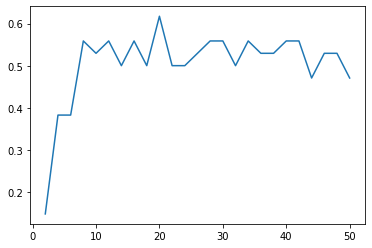

In [58]:
plt.plot(range(2, 51, 2), accuracies)

In [ ]:

for lr in ['1e-4']:
    for lr_step in ['40', '80', '120']:

        accuracies = list()


        for i in range(10, 301, 10):
            model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 128}, 
                            head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = True)

            model = load_model(model, f'../exp/mot/lemur_ids_roi_only_gc_{lr_step}_{lr}/model_{str(i)}.pth')
            model = model.to(torch.device('cuda'))
            model.eval();


            accuracy = 0
            gt = []
            pred = []

            for i in tqdm(range(dset.__len__())):
        # for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
                    
                image, img_path, original_shape, labels = dset.__getitem__(i)
                im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

                width = im_blob.shape[3]
                height = im_blob.shape[2]
                inp_height = im_blob.shape[2]
                inp_width = im_blob.shape[3]
                h_out = inp_height // 4
                w_out = inp_width // 4



                with torch.no_grad():
                    output = model(im_blob)[-1]
                    hm = output['hm'].sigmoid_()
                    wh = output['wh']
                    id_feature = output['id']
                    id_feature = F.normalize(id_feature, dim=1)
                    reg = output['reg']
                    
                    num_classes = hm.size(1)

                    dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                                    wh=wh,
                                                    reg=reg,
                                                    num_classes=num_classes,
                                                    cat_spec_wh=False,
                                                    K=50)

                # Translate and scale bounding box detections.
                dets = map2orig(dets, h_out, w_out, height, width, num_classes)
                
                # Only keep lemur predictions.
                dets = dets[0]
                dets_bbox = torch.from_numpy(dets)
                remain_inds = dets_bbox[:, 4] > 0.04
                dets_bbox = dets_bbox[remain_inds]
                
                # Only keep lemur ground truth boxes.
                labels = labels[labels[:, 0]==0]

                # Id classification logits per lemur detection
                cls_logits = model.gc_lin(output['gc'], bboxes=[dets_bbox[:, :4].cuda() / 4]).cpu()
                dets_class = torch.argmax(cls_logits, dim=1)

                # Translate and scale ground truth bounding boxes.
                gt_bbox = torch.Tensor(labels[:, 2:6]) # * np.array([width, height, width, height]))
            #     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")
                
                assert gt_bbox.size(0) == 1
                
                iou_matrix = torchvision.ops.box_iou(gt_bbox, dets_bbox[:, :4]).numpy()
                
                accuracy += int(dets_class[np.argmax(iou_matrix)] == int(labels[:, -1]))
                gt.append(class_names[dets_class[np.argmax(iou_matrix)]])
                pred.append(class_names[int(labels[:, -1])])

            accuracy /= i + 1
            accuracies.append(accuracy)

        plt.plot(range(10, 301 ,10), accuracies)
        plt.savefig(f'/usr/users/vogg/temp_validation/gc_loss1/performance_{lr_step}_{lr}.png')
        plt.close()

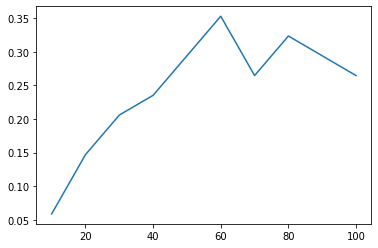

In [ ]:

for lr in ['1e-4']:
    for lr_step in ['40', '80', '120']:

        accuracies = list()


        for i in range(2, 81, 2):
            model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 128}, 
                            head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = False)

            model = load_model(model, f'../exp/mot/lemur_ids_only_gc_{lr_step}_{lr}/model_{str(i)}.pth')
            model = model.to(torch.device('cuda'))
            model.eval();


            accuracy = 0
            gt = []
            pred = []

            for i in tqdm(range(dset.__len__())):
            # for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
                
                image, img_path, original_shape, labels = dset.__getitem__(i)
                im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

                width = im_blob.shape[3]
                height = im_blob.shape[2]
                inp_height = im_blob.shape[2]
                inp_width = im_blob.shape[3]
                h_out = inp_height // 4
                w_out = inp_width // 4



                with torch.no_grad():
                    output = model(im_blob)[-1]
                    hm = output['hm'].sigmoid_()
                    wh = output['wh']
                    id_feature = output['id']
                    id_feature = F.normalize(id_feature, dim=1)
                    reg = output['reg']
                    
                    num_classes = hm.size(1)

                    dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                                    wh=wh,
                                                    reg=reg,
                                                    num_classes=num_classes,
                                                    cat_spec_wh=False,
                                                    K=50)
                    
                    # Spatial indices of lemur detections
                    lemur_detect_inds = inds[:, cls_inds_mask[0]]

                    # Id classification logits per lemur detection
                    cls_logits = model.gc_lin(output['gc'], lemur_detect_inds).cpu().numpy()

                # Translate and scale bounding box detections.
                dets = map2orig(dets, h_out, w_out, height, width, num_classes)
                
                
                # Only keep lemur predictions.
                dets_bbox = dets[0]
                dets_class = np.argmax(cls_logits, axis=1)
                dets_conf = np.max(cls_logits, axis = 1)


                remain_inds = dets_bbox[:, 4] > 0.01
                dets_bbox = dets_bbox[remain_inds]
                dets_class = dets_class[remain_inds]
                dets_conf = dets_conf[remain_inds]
                
                # Only keep lemur ground truth boxes.
                labels = labels[labels[:, 0]==0]

                # Translate and scale ground truth bounding boxes.
                gt_bbox = torch.Tensor(labels[:, 2:6]) # * np.array([width, height, width, height]))
            #     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")
                
                assert gt_bbox.size(0) == 1
                
                iou_matrix = torchvision.ops.box_iou(gt_bbox, torch.from_numpy(dets_bbox[:, :4])).numpy()
                
                #print("pred", dets_class[np.argmax(iou_matrix)])
                #print("gt", int(labels[:, -1]))
                gt.append(class_names[dets_class[np.argmax(iou_matrix)]])
                pred.append(class_names[int(labels[:, -1])])
                accuracy += int(dets_class[np.argmax(iou_matrix)] == int(labels[:, -1]))

                #print("conf", dets_conf[np.argmax(iou_matrix)])

            accuracy /= i + 1
            accuracies.append(accuracy)

        plt.plot(range(2, 81 ,2), accuracies)
        plt.savefig(f'/usr/users/vogg/temp_validation/gc_loss1_midpoint/performance_{lr_step}_{lr}.png')
        plt.close()

### Run evaluation for detections

In [23]:
df = pd.DataFrame(columns = ['model', 'valset', 'seed', 'AP', 'AP50', 'AP75'])

mean_ap = MeanAveragePrecision()
for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
    
    image, img_path, original_shape, labels = dset.__getitem__(i)

    im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

    width = im_blob.shape[3]
    height = im_blob.shape[2]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4


    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']
        
        num_classes = hm.size(1)

    dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)

    # Translate and scale bounding box detections.
    dets = map2orig(dets, h_out, w_out, height, width, num_classes)
    
    dets_bbox = torch.from_numpy(np.concatenate([*dets.values()]))
    dets_class = torch.cat([torch.zeros(len(dets[0])), torch.ones(len(dets[1]))])

    remain_inds = dets_bbox[:, 4] > 0.1
    dets_bbox = dets_bbox[remain_inds]
    dets_class = dets_class[remain_inds]

    # Translate and scale ground truth bounding boxes.
    gt_bbox = torch.Tensor(labels[:, 2:6]) #* np.array([width, height, width, height]))
#     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")

    mean_ap.update(
        [dict(boxes=dets_bbox[:, :4], scores=dets_bbox[:, 4], labels=dets_class)],
        [dict(boxes=gt_bbox, labels=torch.from_numpy(labels[:, 0]))],
    )

100%|██████████| 34/34 [00:03<00:00, 11.26it/s]


In [24]:
scores = mean_ap.compute()
mdl = 'test1'
valset = 'lemur_id_train'
seed = 0
print({'model': mdl, 'valset': valset, 'seed': seed, 
          'AP': scores['map'], 'AP50': scores['map_50'], 'AP75': scores['map_75']})
df = pd.concat([df, pd.DataFrame({'model': mdl, 'valset': valset, 'seed': seed, 
          'AP': scores['map'].numpy(), 'AP50': scores['map_50'].numpy(), 'AP75': scores['map_75'].numpy()}, index = [0])])

{'model': 'test1', 'valset': 'lemur_id_train', 'seed': 0, 'AP': tensor(0.6410), 'AP50': tensor(0.9089), 'AP75': tensor(0.7157)}


In [25]:
color_dict = {
    0: (255, 0, 0),
    1: (255, 255, 0),
}

def plotBBox(image, bboxes, labels, colors=color_dict):
    
    image = image.copy()

    for i in range(len(bboxes)):
        low_left = np.array([bboxes[i, 0], bboxes[i, 1]]).astype(int)
        up_right = np.array([bboxes[i, 2], bboxes[i, 3]]).astype(int)

        image = cv2.rectangle(image, low_left, up_right, color=color_dict[labels[i]], thickness = 5)

    return image #cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [26]:
img0 = np.moveaxis(image, 0, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth')

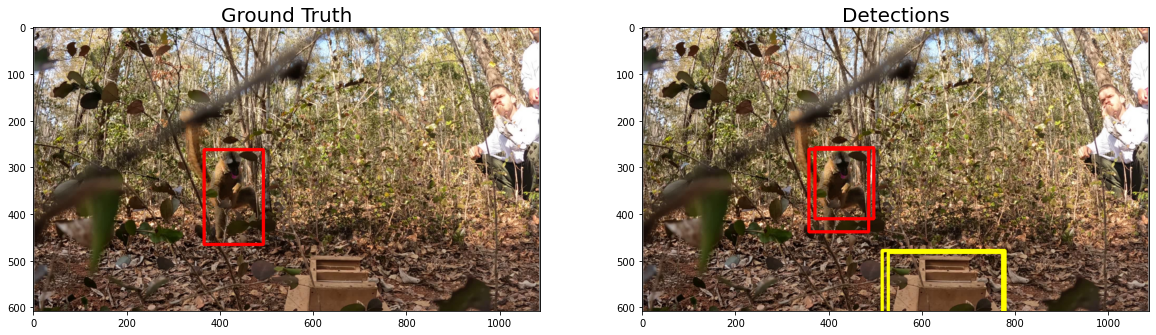

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[1].imshow(plotBBox(img0, dets_bbox, dets_class.numpy()))
ax[0].imshow(plotBBox(img0, gt_bbox, labels[:, 0]))

ax[1].set_title('Detections', fontsize=20)
ax[0].set_title('Ground Truth', fontsize=20)

### Lemur ID classification

In [7]:
def plot_bbox_w_id(image, bboxes):
    
    image = image.copy()

    coords = []
    for i in range(len(bboxes)):
        up_left = np.array([bboxes[i, 0], bboxes[i, 1]]).astype(int)
        low_right = np.array([bboxes[i, 2], bboxes[i, 3]]).astype(int)

        image = cv2.rectangle(image, up_left, low_right, color=(255, 255, 0), thickness = 5)
        coords.append(up_left)

    return image, coords #cv2.cvtColor(image, cv2.COLOR_BGR2RGB), coords

In [32]:
labels_lemurs = labels[labels[:, 0]==0]
bboxes_lemurs = gt_bbox[labels[:, 0]==0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth')

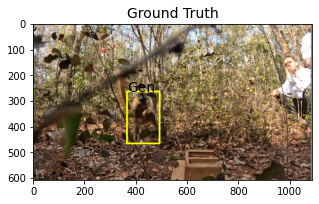

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

image, coords = plot_bbox_w_id(img0, bboxes_lemurs)
ax.imshow(image)

for i, c in enumerate(coords):
    ax.annotate(class_names[int(labels_lemurs[i, -1])], c, fontsize=14)

ax.set_title('Ground Truth', fontsize=14)

In [55]:
df = pd.DataFrame(columns = ['model', 'valset', 'seed', 'AP', 'AP50', 'AP75'])


mean_ap = MeanAveragePrecision()

for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
    
    image, img_path, original_shape, labels = dset.__getitem__(i)
    im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

    width = im_blob.shape[3]
    height = im_blob.shape[2]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4


    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']
        
        num_classes = hm.size(1)

        dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)
        
        # Spatial indices of lemur detections
        lemur_detect_inds = inds[:, cls_inds_mask[0]]

        # Id classification logits per lemur detection
        #cls_logits = model.gc_lin(output['gc'], lemur_detect_inds).cpu()

    # Translate and scale bounding box detections.
    dets = map2orig(dets, h_out, w_out, height, width, num_classes)
    
    # Only keep lemur predictions.
    dets = dets[0]

    dets_bbox = torch.from_numpy(dets)
    dets_class = torch.argmax(cls_logits, dim=1) ###############################Weird that cls_logits is called here!
    remain_inds = dets_bbox[:, 4] > 0.1
    dets_bbox = dets_bbox[remain_inds]
    dets_class = dets_class[remain_inds]
    
    # Only keep lemur ground truth boxes.
    labels = labels[labels[:, 0]==0]

    # Id classification logits per lemur detection
#     cls_logits = model.gc_lin(output['gc'], bboxes=[dets_bbox[:, :4].cuda()]).cpu()
#     dets_class = torch.argmax(cls_logits, dim=1)
    cls_logits = model.gc_lin(output['gc'], bboxes=[dets_bbox[:, :4].cuda() / 4]).cpu() 
    dets_class = torch.argmax(cls_logits, dim=1)

    # Translate and scale ground truth bounding boxes.
    gt_bbox = torch.Tensor(labels[:, 2:6])# * np.array([width, height, width, height]))
#     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")

    mean_ap.update(
        [dict(boxes=dets_bbox[:, :4], scores=dets_bbox[:, 4], labels=dets_class)],
        [dict(boxes=gt_bbox, labels=torch.from_numpy(labels[:, -1]))],
    )

  0%|          | 0/315 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 4)

In [30]:
scores = mean_ap.compute()
mdl = 'test1'
valset = 'lemur_id_train'
seed = 0
print({'model': mdl, 'valset': valset, 'seed': seed, 
          'AP': scores['map'], 'AP50': scores['map_50'], 'AP75': scores['map_75']})
df = pd.concat([df, pd.DataFrame({'model': mdl, 'valset': valset, 'seed': seed, 
          'AP': scores['map'].numpy(), 'AP50': scores['map_50'].numpy(), 'AP75': scores['map_75'].numpy()}, index = [0])])

{'model': 'test1', 'valset': 'lemur_id_train', 'seed': 0, 'AP': tensor(0.1927), 'AP50': tensor(0.3165), 'AP75': tensor(0.2037)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth')

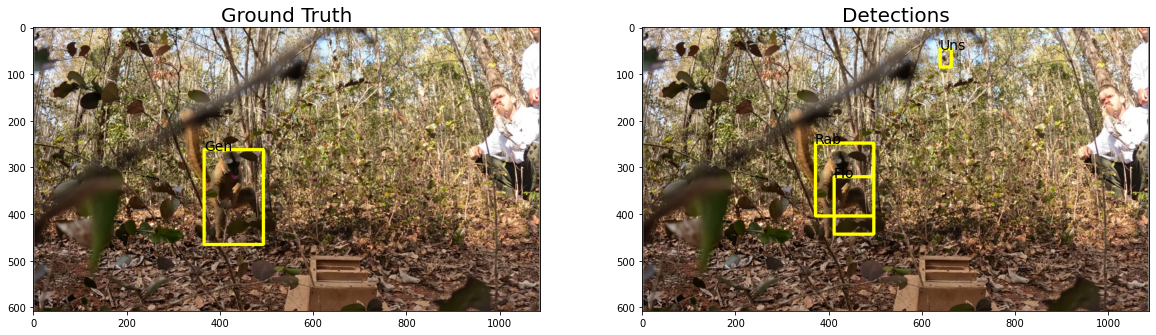

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

image, coords = plot_bbox_w_id(img0, gt_bbox)
image2, coords2 = plot_bbox_w_id(img0, dets_bbox)

ax[0].imshow(image)
ax[1].imshow(image2)

for i, c in enumerate(coords):
    ax[0].annotate(class_names[int(labels[i, -1])], c, fontsize=14)
    
for i, c in enumerate(coords2):
    ax[1].annotate(class_names[int(dets_class[i])], c, fontsize=14)

ax[1].set_title('Detections', fontsize=20)
ax[0].set_title('Ground Truth', fontsize=20)

#### Check DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth')

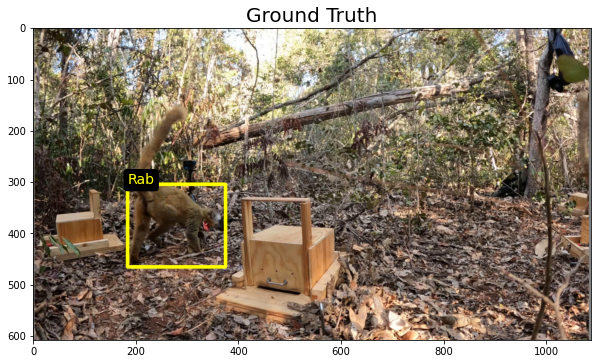

In [24]:
dset = dataset.ImageLabelDataset(
    root='/usr/users/agecker/datasets/lemur_ids/',
    file_list='/usr/users/vogg/monkey-tracking-in-the-wild/src/data/lemur_ids.val',
    resize=True
    )



i = 5

image, img_path, original_shape, labels = dset.__getitem__(i)
img0 = np.moveaxis(image, 0, -1)
# Translate and scale ground truth bounding boxes.
gt_bbox = torch.Tensor(labels[:, 2:6]) #* np.array([width, height, width, height]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

image, coords = plot_bbox_w_id(img0, gt_bbox)
#image2, coords2 = plot_bbox_w_id(img0, dets_bbox)

ax.imshow(image)

for i, c in enumerate(coords):
    ax.annotate(class_names[int(labels[i, -1])], c, fontsize=14, color = "yellow",
                bbox=dict(boxstyle='round', facecolor='black', edgecolor='none'))
    

ax.set_title('Ground Truth', fontsize=20)




In [7]:
class opts:
    pass

opt = opts()
opt.use_gc = True
opt.gc_cls_names = "Cha,Flo,Gen,Geo,Her,Rab,Red,Uns"
opt.reid_cls_names = "lemur,box"
opt.cat_spec_wh = True
opt.K = 50
opt.down_ratio = 4
opt.ltrb = False
opt.mse_loss = True
opt.gc_with_roi = True
opt.hm_gauss = True
opt.no_aug_hsv = False
opt.gc_with_roi = True


dset = dataset.JointDataset2(
    opt,
    root='/usr/users/agecker/datasets/',
    paths={
		"lemur_train": '/usr/users/vogg/monkey-tracking-in-the-wild/src/data/lemur_box_sep22.train'
	},
    augment=True, transforms = T.Compose([T.ToTensor()])
    )

dataset summary
OrderedDict([('lemur_train', defaultdict(<class 'int'>, {0: 1359.0, 1: 1336.0, 465: 0.464098, 776: 0.959716, 930: 0.52014, 1069: 0.567688, 673: 0.291068, 850: 0.872227, 1147: 0.846235, 228: 0.487701, 1148: 0.503328, 443: 0.475919, 797: 0.939336, 1166: 0.512785, 149: 0.478075, 1168: 0.846235, 1157: 0.515236, 1223: 0.687566, 800: 0.939336, 958: 0.542207, 695: 0.107867, 970: 0.666287, 724: 0.446256, 1253: 0.964623, 803: 0.5909, 531: 0.920928, 1063: 0.568126, 835: 0.503318, 1163: 0.508231, 766: 0.409668, 956: 0.450701, 196: 0.091622, 822: 0.26218, 1165: 0.831962, 1308: 0.120841, 951: 0.534501, 534: 0.920928, 1176: 0.973292, 359: 0.521541, 39: 0.76934, 216: 0.823173, 370: 0.601926, 180: 0.365775, 253: 0.437968, 693: 0.107867, 246: 0.450624, 1078: 0.567688, 148: 0.584314, 480: 0.731349, 1151: 0.590193, 198: 0.091622, 168: 0.473797, 730: 0.446256, 5: 0.34606, 1071: 0.566813, 238: 0.450624, 806: 0.448341, 166: 0.471836, 556: 0.511384, 1076: 0.568126, 601: 0.60035, 907: 0.497723

In [9]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 3}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = True)

print(os.getcwd())
model = load_model(model, '../exp/mot/lemur_ids_roi/model_10.pth')
model = model.to(torch.device('cuda'))
model.eval();

/usr/users/vogg/monkey-tracking-in-the-wild/notebooks
loaded ../exp/mot/lemur_ids_roi/model_10.pth, epoch 10


In [8]:

i = 39

output = dset.__getitem__(i)

bbox = output['bbox']
input_image = output['input'].numpy()
box_lemur = output['box_lemur_class'].numpy()
labels = output['gc'].numpy()

img0 = np.moveaxis(input_image, 0, -1)
gt_bbox = bbox[:len(box_lemur)][box_lemur == 0] #ignore foodboxes

ValueError: cannot reshape array of size 36 into shape (7)

In [9]:
output

NameError: name 'output' is not defined

In [12]:
im_blob = torch.from_numpy(input_image).cuda().unsqueeze(0)

width = im_blob.shape[3]
height = im_blob.shape[2]
h_out = height // 4
w_out = width // 4


with torch.no_grad():
    output = model(im_blob)[-1]
    hm = output['hm'].sigmoid_()
    wh = output['wh']
    id_feature = output['id']
    id_feature = F.normalize(id_feature, dim=1)
    reg = output['reg']
    
    num_classes = hm.size(1)

dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                        wh=wh,
                                        reg=reg,
                                        num_classes=num_classes,
                                        cat_spec_wh=False,
                                        K=50)

# Translate and scale bounding box detections.
dets = map2orig(dets, h_out, w_out, height, width, num_classes)

# Only keep lemur predictions.
dets = dets[0]

dets_bbox = torch.from_numpy(dets)
cls_logits = model.gc_lin(output['gc'], bboxes=[dets_bbox[:, :4].cuda() / 4]).cpu()
dets_class = torch.argmax(cls_logits, dim=1)
remain_inds = dets_bbox[:, 4] > 0.3
dets_bbox = dets_bbox[remain_inds]
dets_class = dets_class[remain_inds]
cls_logits = cls_logits[remain_inds]


TypeError: forward() got an unexpected keyword argument 'bboxes'

In [21]:
cls_logits.detach().numpy()

array([[5.9705511e-05, 7.0073605e-05, 1.8797056e-01, 6.2992471e-01,
        4.4509119e-04, 2.5544744e-03, 1.1462197e-01, 6.4353362e-02]],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth')

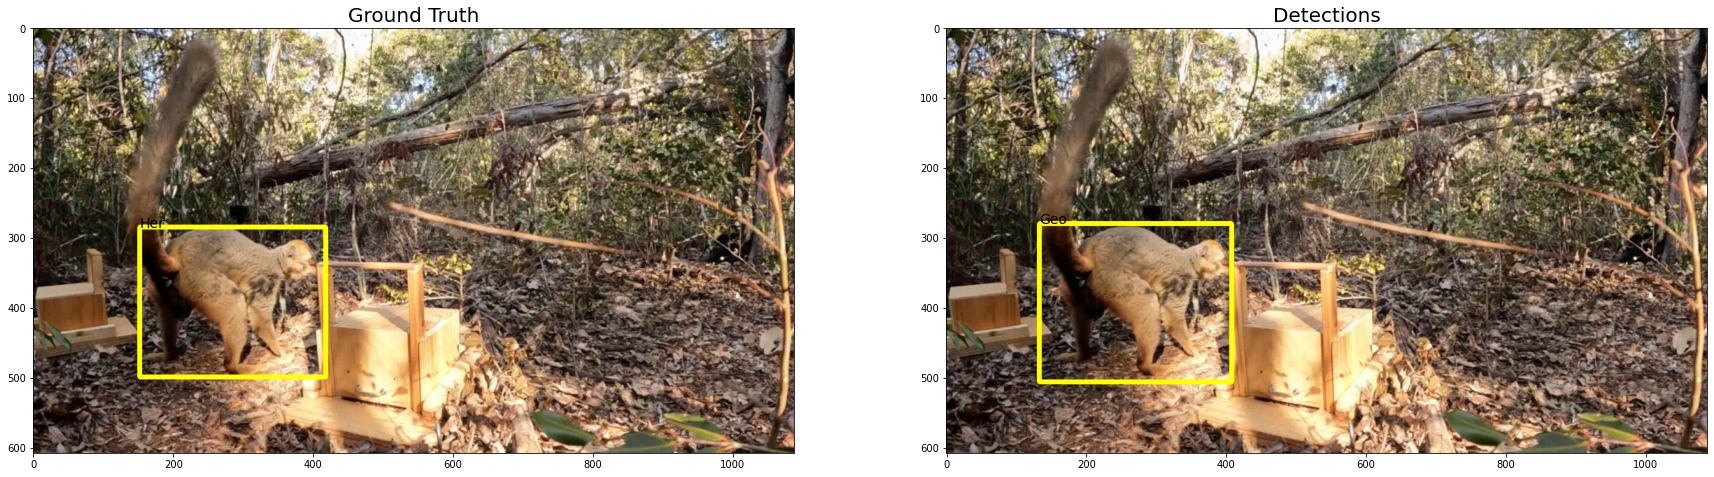

In [22]:
ig, ax = plt.subplots(1, 2, figsize=(30, 12))

image, coords = plot_bbox_w_id(img0, gt_bbox * 4)
image2, coords2 = plot_bbox_w_id(img0, dets_bbox)

ax[0].imshow(image)
ax[1].imshow(image2)

for i, c in enumerate(coords):
    ax[0].annotate(class_names[int(labels[i])], c, fontsize=14)
    
for i, c in enumerate(coords2):
    ax[1].annotate(class_names[int(dets_class[i])], c, fontsize=14)

ax[1].set_title('Detections', fontsize=20)
ax[0].set_title('Ground Truth', fontsize=20)

In [12]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, emb_dim=128, num_classes=6):
        super().__init__()
        #self.conv1 = nn.Conv2d(emb_dim, 128, 5)
        #self.conv2 = nn.Conv2d(128, 64, 5)
        #self.conv3 = nn.Conv2d(64, 32, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.conv1 = nn.Conv2d(emb_dim, 32, 3)
        self.global_avg_pooling = nn.AvgPool2d(61)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        #x = torch.flatten(x, 1)  # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        x = F.relu(self.conv1(x))
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc2(x)
        return x

In [13]:
cnn = CNN()

In [14]:
cnn

CNN(
  (conv1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1))
  (global_avg_pooling): AvgPool2d(kernel_size=61, stride=61, padding=0)
  (fc2): Linear(in_features=32, out_features=6, bias=True)
)